Benchmark of MOB


In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mucostx as mx

In [2]:
opt = mx.config()
args = opt.parse_args(['--gpu', '0'])
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MOB/'
args.elastic_corr = True
args.srt_resolution = 50
if args.version.split('-')[0] != 'dev':
    warnings.filterwarnings("ignore")
args

Namespace(amp=True, batch_size=512, clusters=0, dataset_path='/mnt/d/Dataset/SRT_Dataset/MOB/', dropout=0.3, elastic_corr=True, flow='source_to_target', gpu=0, hvgs=3000, latent_dim=64, log_file='../Log', log_steps=20, lr=0.001, max_epoch=100, max_neighbors=6, mode_rknn='rknn', n_spot=0, out_file='../Output', project_name='MoCoSTX', seed=2024, srt_resolution=50, tau=0.05, version='dev-1.0', visual=True, wegiht_decay=0.0001)

In [3]:
mx.set_random_seed(args.seed)

In [4]:
# sections = ['151673', '151674', '151675', '151676']
sections = ['Stereo-seq_MoB.h5ad', 'Slide-seqV2_MoB.h5ad']
# sections = ['151507', '151508', '151509', '151510','151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']

In [5]:
adata_list = []
for section in sections:
    # adata = sc.read_visium(os.path.join(args.dataset_path+section))
    adata = sc.read_h5ad(os.path.join(args.dataset_path+section))
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=50)
    adata_list.append(adata)
adata_list

[AnnData object with n_obs × n_vars = 19109 × 14376
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 20139 × 11750
     var: 'n_cells'
     obsm: 'spatial']

Before alignment

In [6]:
adata_raw = ad.concat(adata_list, keys=sections,label="slice_name", join='inner')
sc.pp.highly_variable_genes(adata_raw, flavor="seurat_v3", n_top_genes=3000)
global_hvg = adata_raw.var_names[adata_raw.var['highly_variable']]
sc.pp.filter_cells(adata_raw, min_genes=200)
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
adata_raw = adata_raw[:, global_hvg]
sc.pp.scale(adata_raw, zero_center=True, max_value=10)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [7]:
adata_raw.obsm['spatial']

array([[ 6307.53785901, 12555.0078329 ],
       [ 9153.20472441, 12993.42913386],
       [ 9154.77625571, 11058.83561644],
       ...,
       [ 1508.        ,  3794.2       ],
       [ 2008.8       ,  5087.2       ],
       [ 4472.7       ,  4657.6       ]])

In [8]:
def mclust(adata, arg):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=32, random_state=arg.seed)
    embedding = pca.fit_transform(adata.X.copy())
    adata.obsm['emb_pca'] = embedding
    import rpy2.robjects as r_objects
    r_objects.r.library("mclust")
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = r_objects.r['set.seed']
    r_random_seed(arg.seed)
    rmclust = r_objects.r['Mclust']
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm['emb_pca']), arg.n_domain, 'EEE')

    mclust_res = np.array(res[-2])
    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')

    return adata

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


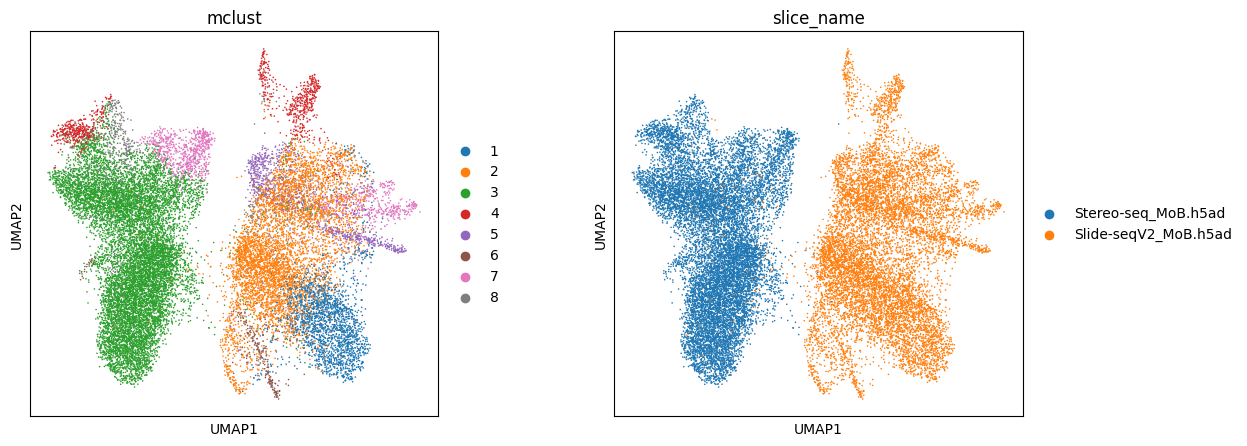

In [9]:
args.n_domain=8
adata_new0 = mclust(adata_raw, args)
sc.pp.neighbors(adata_new0, use_rep='emb_pca')
sc.tl.umap(adata_new0)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_new0, color=["mclust", 'slice_name'], ncols=3,wspace=0.3, show=True)


In [10]:
mucostx = mx.MuCoSTX(adata_list, args)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


section 14044 and 10525 has 149909 mnn edges
Get the overall mnn graph...
number of node: 24569, 24569
number of edges: 299818
edge_index:
tensor([[    0,     0,     0,  ..., 24568, 24568, 24568],
        [14528, 15448, 15676,  ..., 11574, 12300, 13342]])
Data(x=[24569, 3003], edge_index=[2, 141464]) Data(x=[24569, 3003], edge_index=[2, 441282], edge_attr=[441282])


  0%|          | 0/100 [00:00<?, ?it/s]

rec: 0.9384031295776367, ctr: 0.5048889517784119, orth: 53.653202056884766, pano: 0.06221773102879524 0.00047014665324240923
rec: 0.9191146492958069, ctr: 0.4352949559688568, orth: 44.39476013183594, pano: 0.06247736141085625 0.00043446256313472986
rec: 0.9188521504402161, ctr: 0.4345594346523285, orth: 35.761592864990234, pano: 0.06195279583334923 0.0005214462871663272
rec: 0.9243173599243164, ctr: 0.45952048897743225, orth: 29.727914810180664, pano: 0.06184741482138634 0.0005202092579565942
rec: 0.9001981019973755, ctr: 0.49848175048828125, orth: 25.96971893310547, pano: 0.06165146827697754 0.0005951165221631527
rec: 0.9124219417572021, ctr: 0.45898112654685974, orth: 21.337800979614258, pano: 0.06145069748163223 0.0006087510846555233
rec: 0.902346670627594, ctr: 0.45321688055992126, orth: 18.091928482055664, pano: 0.061443991959095 0.0010050140554085374
rec: 0.8912678956985474, ctr: 0.46330705285072327, orth: 16.26337432861328, pano: 0.061379324644804 0.0005680712638422847
rec: 0.89

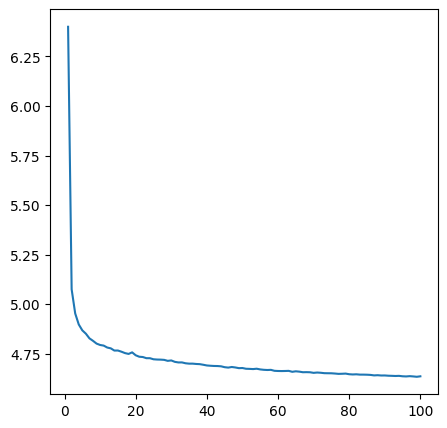

In [11]:
mucostx.train_emb()

Downstream workflow

In [12]:
list_new = mucostx.get_adata_all()
list_new

[AnnData object with n_obs × n_vars = 14044 × 3000
     obs: 'n_genes'
     var: 'n_cells', 'mean', 'std'
     uns: 'log1p'
     obsm: 'spatial', 'X_pca', 'mxb', 'mx',
 AnnData object with n_obs × n_vars = 10525 × 3000
     obs: 'n_genes'
     var: 'n_cells', 'mean', 'std'
     uns: 'log1p'
     obsm: 'spatial', 'X_pca', 'mxb', 'mx']

绘制等高线

In [13]:
# import scanpy as sc
# import matplotlib.pyplot as plt
# import numpy as np

# # 假设 'isodepth' 存在于 adata.obs 或 adata.obsm
# # 并且空间坐标信息存储在 adata.obsm['spatial']

# # 1. 绘制基本的空间坐标图
# fig, ax = plt.subplots(figsize=(8, 8))

# # 画散点图
# sc.pl.spatial(list_new[0], color=['isodepth'], ax=ax, show=False, spot_size=50)

# # 2. 获取空间坐标和 isodepth 的值
# spatial_coords = list_new[0].obsm['spatial']  # 2D 坐标
# isodepth_values = list_new[0].obs['isodepth']  # isodepth 值

# # 3. 将空间坐标和 isodepth 值转换为网格，以便绘制等高线
# # 对坐标进行网格化处理
# xi = np.linspace(spatial_coords[:, 0].min(), spatial_coords[:, 0].max(), 100)
# yi = np.linspace(spatial_coords[:, 1].min(), spatial_coords[:, 1].max(), 100)

# # 创建网格
# X, Y = np.meshgrid(xi, yi)

# # 对 isodepth 值进行插值
# from scipy.interpolate import griddata
# Z = griddata(spatial_coords, isodepth_values, (X, Y), method='linear')

# # 4. 绘制等高线
# # 等高线的间隔为 0.2
# contour = ax.contour(X, Y, Z, levels=np.arange(0, 1.1, 0.2), cmap='viridis', alpha=0.7)

# # 5. 添加颜色条
# fig.colorbar(contour.collections[0], ax=ax, label='isodepth')

# # 显示图形
# plt.show()

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scanpy as sc
# from scipy.stats import gaussian_kde

# # 假设 isodepth 存储在 adata.obsm['isodepth'] 和空间坐标在 adata.obsm['spatial']
# isodepth = list_new[9].obs['isodepth']  # 或者从 adata.obsm['isodepth'] 提取
# spatial_coords = list_new[9].obsm['spatial']

# # 1. 核密度估计（KDE）
# # 使用空间坐标和 isodepth 值进行 KDE
# kde = gaussian_kde(spatial_coords.T, weights=isodepth)  # 对坐标进行核密度估计，并按 isodepth 值加权

# # 2. 创建网格用于绘制
# x_min, x_max = spatial_coords[:, 0].min(), spatial_coords[:, 0].max()
# y_min, y_max = spatial_coords[:, 1].min(), spatial_coords[:, 1].max()

# x_grid = np.linspace(x_min, x_max, 100)
# y_grid = np.linspace(y_min, y_max, 100)
# X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# # 3. 计算每个网格点的密度值
# positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])
# density = kde(positions).reshape(X_grid.shape)

# # 4. 绘制等高线
# fig, ax = plt.subplots(figsize=(8, 8))

# # 绘制等高线，levels 定义了每条等高线的值
# contour = ax.contour(X_grid, Y_grid, density, levels=10, cmap='viridis')

# # 可选：添加颜色条
# cbar = plt.colorbar(contour.collections[0], ax=ax)
# cbar.set_label('Density')

# # 可选：绘制散点图
# sc.pl.spatial(list_new[0], color=['isodepth'], ax=ax, show=False)  # 先画灰色的背景散点图

# plt.show()


In [15]:
adata_new1 = ad.concat(list_new, keys=sections,label="slice_name")

In [16]:
adata_new1

AnnData object with n_obs × n_vars = 24569 × 3000
    obs: 'n_genes', 'slice_name'
    obsm: 'spatial', 'X_pca', 'mxb', 'mx'

In [17]:
from mucostx.utils import mclust
args.n_domain=9
adata_new1 = mclust(adata_new1, args, refine=False, use='mxb')

fitting ...
  |======================================================================| 100%


/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


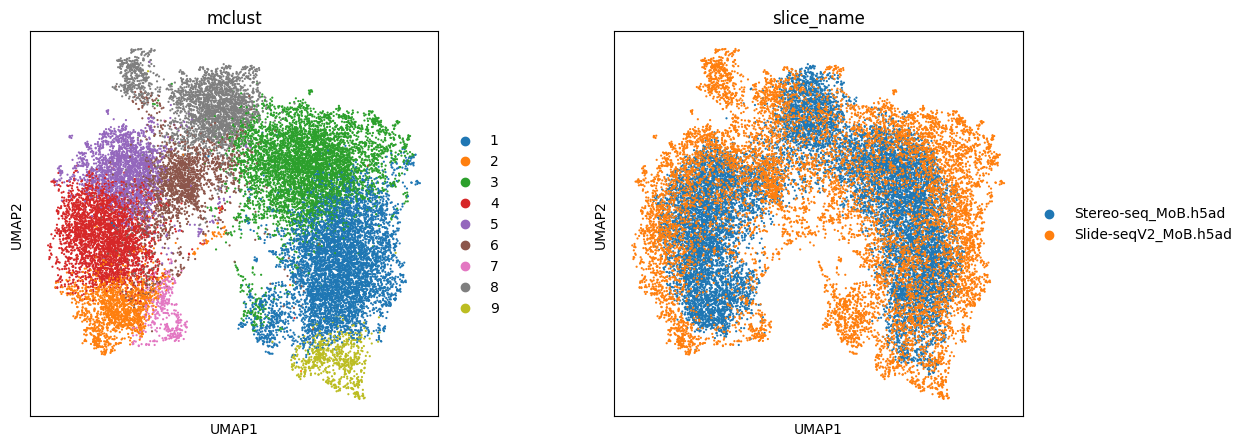

In [18]:
sc.pp.neighbors(adata_new1, use_rep='mxb')
sc.tl.umap(adata_new1)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_new1, color=["mclust", 'slice_name'], size=10, ncols=3,wspace=0.3, show=True)

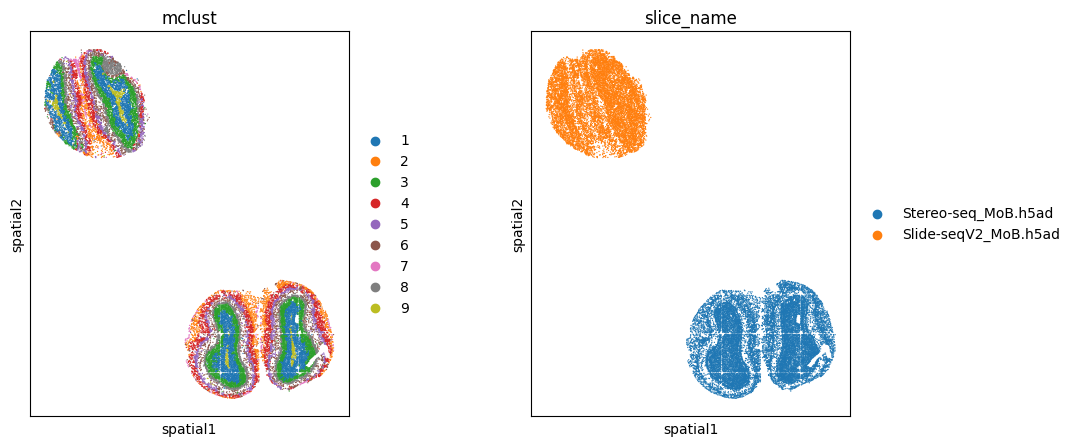

In [19]:
sc.pl.spatial(adata_new1,color=['mclust',"slice_name"], spot_size=50)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


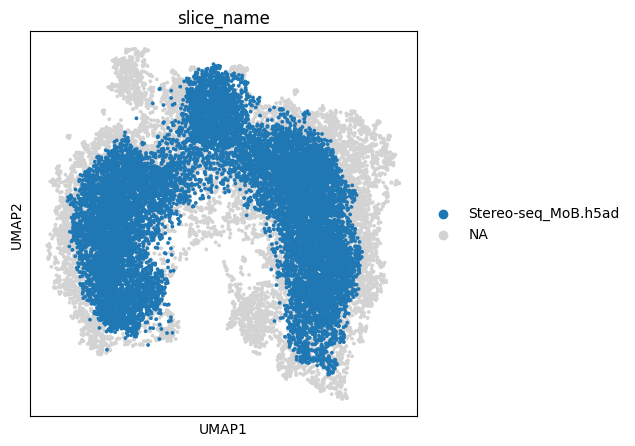

In [20]:
sc.pl.umap(adata_new1, color='slice_name', groups=[sections[0]],size=30)

batch corrected

In [21]:
adata_new = ad.concat(list_new, keys=sections,label="slice_name")
from mucostx.utils import mclust
args.n_domain=9
adata_new = mclust(adata_new, args, refine=False, use='mx')

fitting ...
  |======================================================================| 100%


/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


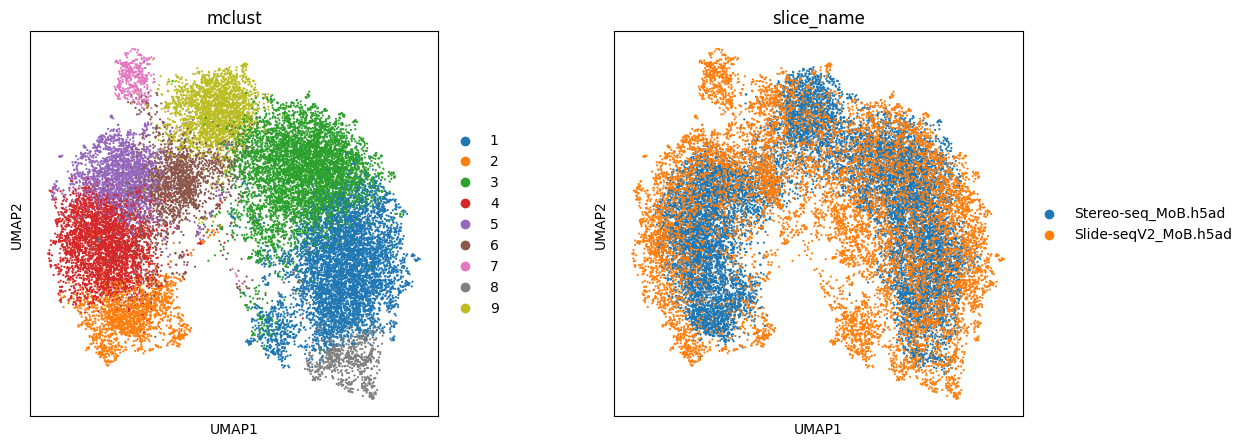

In [22]:
sc.pp.neighbors(adata_new, use_rep='mx')
sc.tl.umap(adata_new)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_new, color=["mclust", 'slice_name'], ncols=3,wspace=0.3, show=True,size=10)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


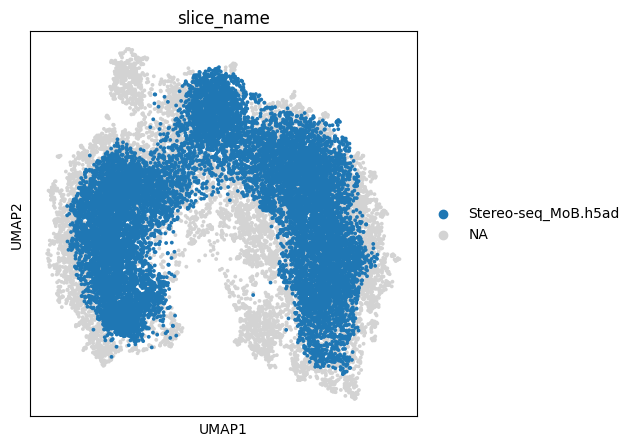

In [23]:
sc.pl.umap(adata_new, color='slice_name', groups=[sections[0]],size=30)

In [24]:
abs(adata_new.obsm['mx'][3]).sum()

117.33273

In [25]:
import torch
aa = mucostx.model.batch_emb(torch.tensor([0]).to('cuda'))
abs(aa).sum()

tensor(11.0277, device='cuda:0', grad_fn=<SumBackward0>)

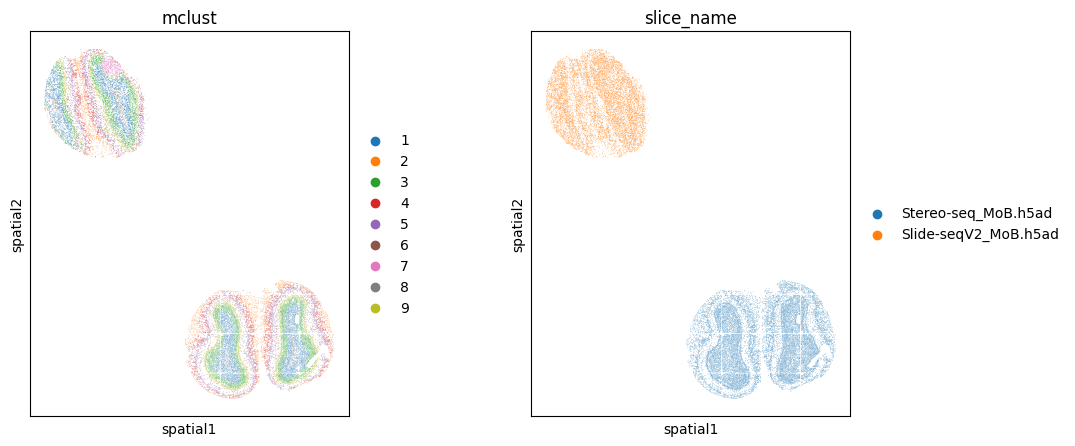

In [26]:
sc.pl.spatial(adata_new,color=['mclust',"slice_name"], spot_size=20)

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


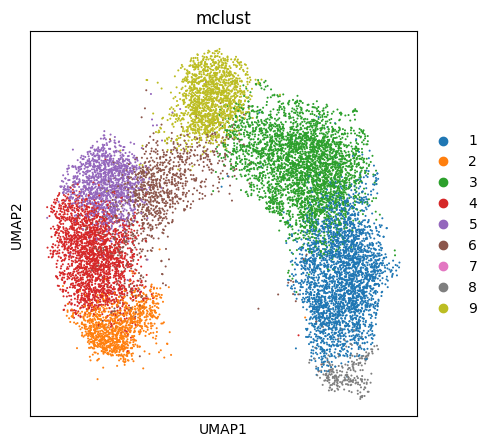

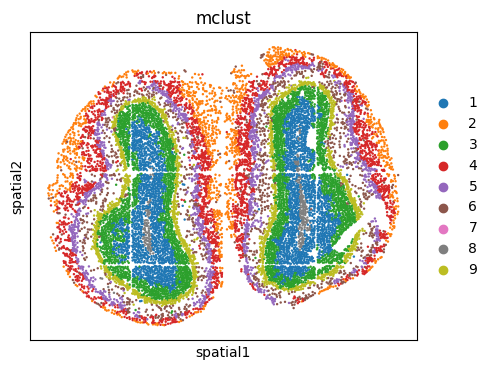

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


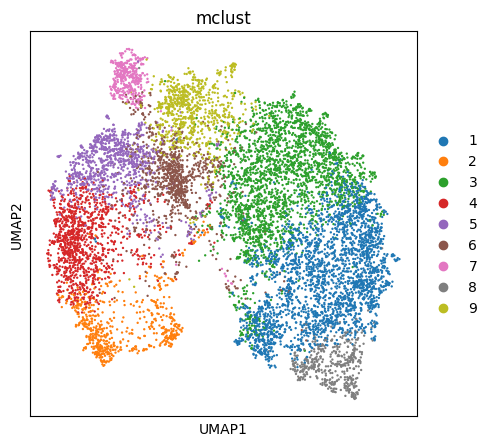

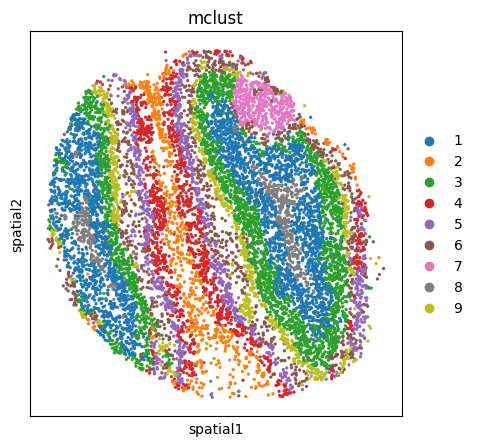

In [27]:
for i, sli in enumerate(sections):
    adata_151 = adata_new[adata_new.obs['slice_name']==sli,:]
    adata_151
    sc.pl.umap(adata_151, color=["mclust"])
    adata_151.uns = adata_list[i].uns
    sc.pl.spatial(adata_151,color=["mclust"], spot_size=40)

In [28]:
import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [110]:
names = ['Stereo-seq_MoB.h5ad', 'Slide-seqV2_MoB.h5ad']
adata_1 = adata_new[adata_new.obs['slice_name']==names[0],:]
adata_2 = adata_new[adata_new.obs['slice_name']==names[1],:]
adata_1, adata_2

(View of AnnData object with n_obs × n_vars = 14044 × 3000
     obs: 'n_genes', 'slice_name', 'mclust'
     uns: 'neighbors', 'umap', 'mclust_colors', 'slice_name_colors'
     obsm: 'spatial', 'X_pca', 'mxb', 'mx', 'emb_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 10525 × 3000
     obs: 'n_genes', 'slice_name', 'mclust'
     uns: 'neighbors', 'umap', 'mclust_colors', 'slice_name_colors'
     obsm: 'spatial', 'X_pca', 'mxb', 'mx', 'emb_pca', 'X_umap'
     obsp: 'distances', 'connectivities')

/home/zl/anaconda3/envs/pyg/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


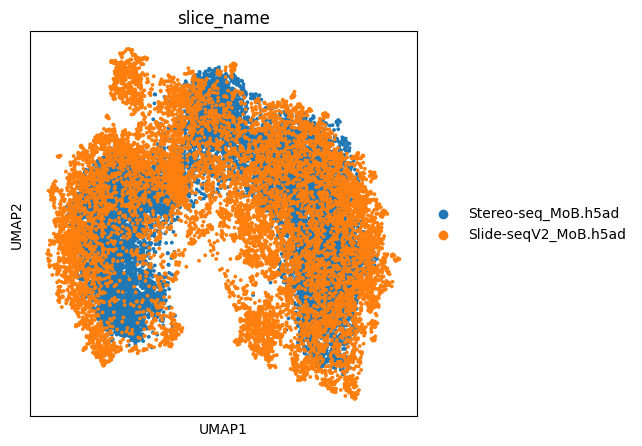

In [111]:
sc.pl.umap(adata_new, color='slice_name', groups=[sections[1],sections[0]],size=30)

In [112]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Module, Sequential, ReLU
class Transfers(Module):
    def __init__(self):
        super().__init__()
        in_dim=64
        self.encoder = Sequential(Linear(in_dim, in_dim), ReLU(), 
                                  Linear(in_dim, in_dim), ReLU(),
                                  Linear(in_dim, 2))
    def forward(self, z, coor):
        pre_coor = self.encoder(z)
        loss = self.loss(coor, pre_coor)
        return loss
        
    def loss(self, coor, pre_coor):
        loss = F.mse_loss(coor, pre_coor)
        return loss

In [129]:
tm = Transfers().to('cuda')
optimizer = torch.optim.Adam(tm.parameters(), lr=1e-3, weight_decay=1e-4)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = tm(torch.tensor(adata_1.obsm['mx']).to('cuda'), torch.tensor(adata_1.obsm['spatial'], dtype=torch.float).to('cuda'))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(tm.parameters(), 5)
    optimizer.step()

In [130]:
adata_1.obsm['spatial']

ArrayView([[ 6307.53785901, 12555.0078329 ],
           [ 9153.20472441, 12993.42913386],
           [ 9154.77625571, 11058.83561644],
           ...,
           [ 9147.48407643, 12933.87261146],
           [ 9155.38990826, 13328.96330275],
           [ 9155.12612613, 12959.04954955]])

In [131]:
tm.encoder(torch.tensor(adata_2.obsm['mx']).to('cuda'))

tensor([[ 8112.8237, 12168.5361],
        [ 9427.2480, 11771.6025],
        [ 8385.3955, 11866.0352],
        ...,
        [ 7482.1631, 11147.8604],
        [ 8733.7559, 10999.3984],
        [ 8168.7163, 10542.2930]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [132]:
new_coor = tm.encoder(torch.tensor(adata_2.obsm['mx']).to('cuda')).cpu().detach().numpy()
adata_2.obsm['spatial_transformed'] = new_coor

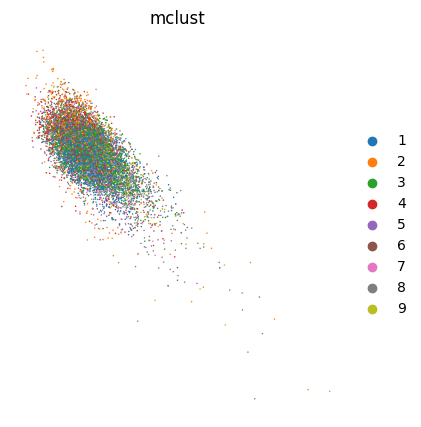

In [133]:
sc.pl.spatial(adata_2, basis='spatial_transformed',color='mclust', spot_size=50, frameon=False)

In [61]:
expr1 = adata_1.obsm['mx']
expr2 = adata_2.obsm['mx']
similarity_matrix = cosine_similarity(expr1, expr2)
similarity_matrix

array([[-1.3964945e-01, -2.8188393e-01, -1.5019557e-01, ...,
        -3.4034818e-01, -2.4914247e-01, -3.5271952e-01],
       [-1.8854417e-01, -2.5042796e-01, -2.0430817e-01, ...,
        -2.8092086e-01, -1.9114558e-01, -3.5302696e-01],
       [-4.1087877e-02, -3.2273293e-01, -1.8107380e-01, ...,
        -3.6024931e-01, -2.8525451e-01, -3.1573308e-01],
       ...,
       [-2.2985549e-01, -1.4989348e-02, -1.7470587e-02, ...,
        -5.6482036e-02, -5.0296735e-02, -2.4207093e-02],
       [-5.4689202e-02,  2.3217333e-02,  7.8562021e-02, ...,
         1.7855878e-01,  2.6977149e-01,  9.5313944e-02],
       [ 2.6879448e-05,  6.2135365e-02, -3.6745615e-02, ...,
         7.9261281e-02, -4.8426283e-03,  6.3662909e-02]], dtype=float32)

In [62]:
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

0         1         2         3         4         5         6      \
0     -0.139649 -0.281884 -0.150196 -0.032651 -0.232244 -0.208551 -0.309524   
1     -0.188544 -0.250428 -0.204308 -0.173480 -0.079153 -0.160062 -0.385753   
2     -0.041088 -0.322733 -0.181074 -0.035572 -0.102809 -0.072270 -0.504369   
3     -0.009113 -0.249454 -0.086482 -0.060848 -0.172894 -0.061531 -0.157597   
4      0.051315  0.378223  0.176023  0.064747  0.247217  0.288680  0.593347   
...         ...       ...       ...       ...       ...       ...       ...   
10520 -0.092248 -0.059442 -0.008004 -0.073908 -0.333403  0.120993  0.153771   
10521 -0.150548 -0.139496 -0.078323 -0.171366 -0.041152 -0.013181 -0.176392   
10522 -0.229855 -0.014989 -0.017471 -0.041219 -0.105054 -0.223738 -0.030788   
10523 -0.054689  0.023217  0.078562 -0.026754 -0.216594  0.191092  0.265570   
10524  0.000027  0.062135 -0.036746 -0.006896  0.044196  0.065751  0.226408   

          7         8         9      ...     14034     14035     14036  \
0     -0.180314 -0.082975 -0.331235  ... -0.142897 -0.413262 -0.160349   
1     -0.221337 -0.121588 -0.264513  ... -0.170029 -0.130706 -0.254909   
2     -0.210288 -0.079996 -0.267360  ... -0.042534 -0.239511 -0.347315   
3     -0.196899 -0.078146 -0.346411  ... -0.120463 -0.377089 -0.369156   
4      0.382924  0.126261  0.282816  ...  0.367943  0.673563  0.536796   
...         ...       ...       ...  ...       ...       ...       ...   
10520 -0.077098 -0.007340 -0.136286  ...  0.070961  0.040722 -0.065708   
10521 -0.186290 -0.220384 -0.107757  ... -0.105003 -0.400442 -0.287438   
10522 -0.148176 -0.062594 -0.242062  ... -0.078408 -0.381230 -0.311708   
10523  0.028682  0.036602 -0.028799  ...  0.167719  0.189863  0.005953   
10524  0.103505  0.026745 -0.067754  ...  0.138088  0.144892  0.164005   

          14037     14038     14039     14040     14041     14042     14043  
0     -0.222722 -0.268601 -0.353334 -0.171314 -0.340348 -0.249142 -0.352720  
1     -0.331359 -0.209135 -0.130028 -0.246191 -0.280921 -0.191146 -0.353027  
2     -0.231458 -0.235795 -0.178759 -0.288586 -0.360249 -0.285255 -0.315733  
3     -0.133983 -0.256422 -0.285413 -0.246691 -0.205014 -0.248961 -0.163213  
4      0.384126  0.519801  0.587540  0.329140  0.479805  0.418633  0.448685  
...         ...       ...       ...       ...       ...       ...       ...  
10520 -0.010269 -0.106927  0.135485 -0.066180  0.089301  0.174271 -0.022606  
10521 -0.163701 -0.270387 -0.359986 -0.133735 -0.110492 -0.308113 -0.126063  
10522 -0.084376 -0.232354 -0.378277 -0.116728 -0.056482 -0.050297 -0.024207  
10523  0.099262  0.016116  0.274043  0.045521  0.178559  0.269771  0.095314  
10524  0.128872  0.144418  0.150447 -0.064452  0.079261 -0.004843  0.063663  

[10525 rows x 14044 columns]

In [63]:
best_match_indices = similarity_df.idxmax(axis=1)
best_match_indices

0        11911
1         2601
2         5436
3         5494
4         7670
         ...  
10520    11839
10521    10589
10522     9524
10523     7595
10524     7112
Length: 10525, dtype: int64

In [64]:
coords_1 = adata_1.obsm['spatial']  # 切片1的空间坐标
coords_2 = adata_2.obsm['spatial']  # 切片2的空间坐标

# 根据best_match_indices选择匹配细胞的坐标
source_pts = coords_1[np.arange(len(best_match_indices)), :]  # 源切片匹配细胞的坐标
target_pts = coords_2[best_match_indices, :]

In [65]:
from skimage.transform import PiecewiseAffineTransform

# 创建 PiecewiseAffineTransform 对象
transform = PiecewiseAffineTransform()

# 估计仿射变换
transform.estimate(source_pts, target_pts)

# 计算变换后的目标坐标
coords_2_transformed = transform(coords_2)

# 将变换后的坐标保存到 adata2 中
adata_2.obsm['spatial_transformed'] = coords_2_transformed

In [66]:
adata_1.obsm['spatial']

ArrayView([[3440.8, 3387.9],
           [3268.1, 3297. ],
           [3555.8, 3476.3],
           ...,
           [1508. , 3794.2],
           [2008.8, 5087.2],
           [4472.7, 4657.6]])

In [67]:
adata_2.obsm['spatial']

array([[ 6307.53785901, 12555.0078329 ],
       [ 9153.20472441, 12993.42913386],
       [ 9154.77625571, 11058.83561644],
       ...,
       [ 9147.48407643, 12933.87261146],
       [ 9155.38990826, 13328.96330275],
       [ 9155.12612613, 12959.04954955]])

In [69]:
adata_2.obsm['spatial_transformed']

array([[-1., -1.],
       [-1., -1.],
       [-1., -1.],
       ...,
       [-1., -1.],
       [-1., -1.],
       [-1., -1.]])

In [68]:
adata_3 = adata_2.copy()
adata_3.obsm['spatial'] = adata_3.obsm['spatial_transformed']

In [41]:
adata_3

AnnData object with n_obs × n_vars = 10525 × 3000
    obs: 'n_genes', 'slice_name', 'mclust'
    uns: 'neighbors', 'umap', 'mclust_colors', 'slice_name_colors'
    obsm: 'spatial', 'X_pca', 'mxb', 'mx', 'emb_pca', 'X_umap', 'spatial_transformed'
    obsp: 'distances', 'connectivities'

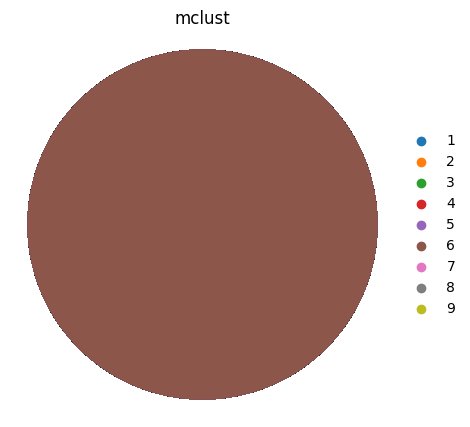

In [50]:
sc.pl.spatial(adata_2, basis='spatial_transformed',color='mclust', spot_size=50, frameon=False)